<a href="https://colab.research.google.com/github/aproca/XAI_course_labs/blob/main/Lab3_SaliencyMapsSolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Saliency Maps

In this notebook, we are going to seek interpretation of convolutional neural networks performing image recognition via saliency maps. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

# Set-up

In [1]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
!wget https://adrian-valente.github.io/assets/feature_images.zip
!unzip feature_images.zip
!mv feature_images/* .

In [2]:
# Load the imagenet class labels
with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [s.strip() for s in f.readlines()]
inverse_imagenet_classes = {k: i for i, k in enumerate(imagenet_classes)}

In [3]:
# Load pretrained model and its associated preprocessing
model = models.vgg16(pretrained=True)
preprocess = models.VGG16_Weights.IMAGENET1K_V1.transforms()
# preprocess = models.ResNet50_Weights.IMAGENET1K_V1.transforms()

/Users/alex/anaconda3/envs/schuessler_lowrank/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alex/anaconda3/envs/schuessler_lowrank/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Put on eval mode
_ = model.eval()

In [5]:
# Test model
image = Image.open('husky.jpg')
inp_tensor = preprocess(image).unsqueeze(0)
out = model.forward(inp_tensor)
print(inp_tensor.shape)

probs = F.softmax(out[0], dim=0).cpu()
top5_prob, top5_catid = torch.topk(probs, 5)
for i in range(top5_prob.size(0)):
    print(imagenet_classes[top5_catid[i]], top5_prob[i].item())

torch.Size([1, 3, 224, 224])
Eskimo dog 0.6298131942749023
Siberian husky 0.34530138969421387
timber wolf 0.008197658695280552
malamute 0.007756785023957491
dogsled 0.0049101850017905235


In [6]:
# A useful construct (listing the architecture of the model)
named_modules = {name: module for name, module in model.named_modules()}
named_modules

{'': VGG(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace=True)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace=True)
     (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace=True)
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace=True)
     (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace=True)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace=True)
     (16): MaxPool2d(kernel_size=2, stride=2

# Saliency Maps

A saliency map represents the pixels that have the highest impact on the decision of a certain network, computed as the gradient of the network's top logit with respect to the input image. More specifically, here we will seek to compute that gradient for each pixel & channel variable in the input image, and then keep the maximal absolute value accross channels for each pixel to ultimately obtain vizualisations of the sort.

#### **Tasks:**
- Complete the saliency map function (step-by-step guide in the comments)


In [7]:
# Complete the following function
def saliency_map(image=None):

    # Boilerplate preprocessing
    if image is None:
      image = torch.tensor([0.485, 0.456, 0.406])
      image = torch.tile(image, (224, 224, 1))\
                      .permute((2, 0, 1))\
                      .unsqueeze(0) 
    else:
      if isinstance(image, Image.Image):
          image = preprocess(image).unsqueeze(0)

    # Define input image as a differentiable variable
    V = torch.autograd.Variable(image, requires_grad=True)

    # Run model
    out = model.forward(V)

    # Extract predicted class
    val, idx = torch.max(out, dim=1)
    probs = F.softmax(out, dim=1)
    print(f'Predicted top class: {imagenet_classes[idx]}, '
          f'p={probs[0, idx].item():.2f}')

    # Backpropagate to get gradient of input image wrt predicted class logit
    val.backward()

    # Process saliency
    saliency = V.grad.squeeze(0)   # Remove batch axis
    # Take abs and max along channels
    saliency = torch.max(torch.abs(saliency), dim=0)[0]
    saliency = saliency.detach().cpu().numpy()  # convert to numpy

    return saliency

Predicted top class: Eskimo dog, p=0.63


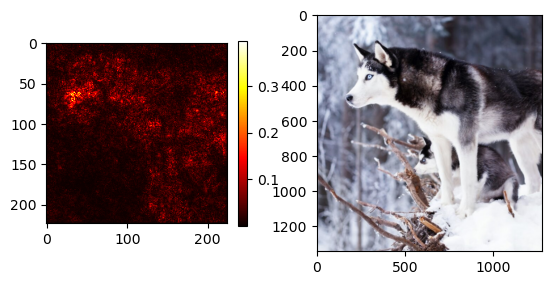

In [8]:
# Testing it
image = Image.open('husky.jpg')
map = saliency_map(image)
fig, ax = plt.subplots(1, 2)
mappable = ax[0].imshow(map, cmap=plt.cm.hot)
fig.colorbar(mappable, shrink=0.5)
ax[1].imshow(image)

Predicted top class: German shepherd, p=0.42


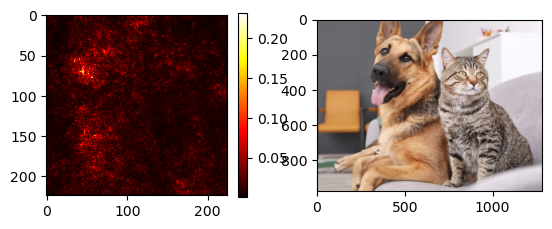

In [9]:
image = Image.open('dog-cat.jpg')
map = saliency_map(image)
fig, ax = plt.subplots(1, 2)
mappable = ax[0].imshow(map, cmap=plt.cm.hot)
fig.colorbar(mappable, shrink=0.5)
ax[1].imshow(image)

#### **Questions:**
Which pixels of the image correspond the strongest to the model's prediction? Does this match your intuition?